In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from dct import create_dct_basis
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-423p8zpj because the default path (/tmp/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Audio Compression

Variants of the DCT algorithm are used heavily in lossy audio compression.  Because an audio signal is saved as a waveform, expressing it as a sum of cosine waves seems obvious here.

Here is a randomly generated waveform:

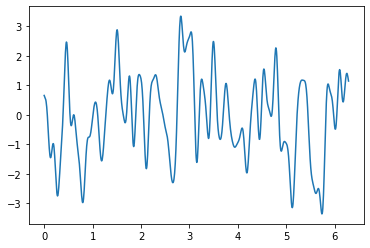

In [2]:
np.random.seed(5)
x = np.linspace(0, 2 * np.pi, 960)
y = np.zeros_like(x)
for i in range(15):
    y += np.cos((x + (np.random.rand() * 10) - 5) * (np.random.rand() * 50)) * np.random.rand()
plt.plot(x, y)

# This is randomly generated -- You can try playing it,
# but I can't guarantee you'll like what you hear :-)

To simplify things computationally, we will break up the data into smaller chunks of $192$ elements.  Why does this help?  Lets explore what happens if we try to compute the DCT basis of an entire $4$ minute song sampled at $44100$ Hz:

$$ \left(4 \text{min} \times 60 \text{sec} \times 44100 \text{Hz}\right)^2 \times 8 \text{ bytes per decimal} \approx 900 \text{TB} $$

So, just a bit too much to store in memory.  How about for just the smaller chunks?

$$ 192^2 \times 8 \text{ bytes per decimal} = 288 \text{Kb} $$

That seems better! We will use for this example `N = 192`. We first need to generate the new basis:

In [3]:
N = 192

D = create_dct_basis(192)

D.shape

(192, 192)

We will get the number of sections needed to split up our data, and save this into `sections`.

In [4]:
sections = len(x) // N
sections

5

Now, lets plot the frequency domain of each section. 


Use the DCT basis given above to convert each section of data into the DCT frequency space, and then plot each to see which frequencies are most dominant.

Essentially, we are plotting $\bar{\bf y} = {\bf D}^T{\bf y}$ for each section of the array ${\bf y}$.

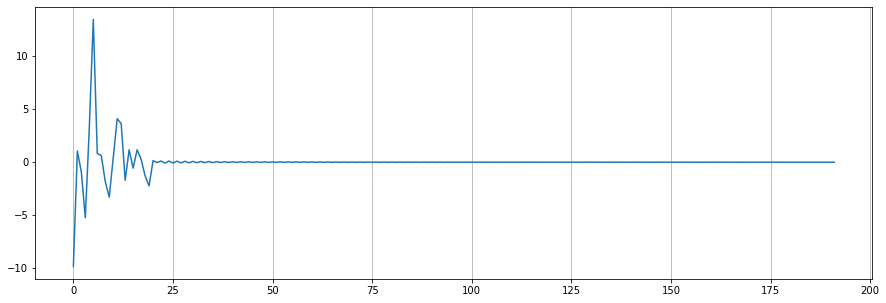

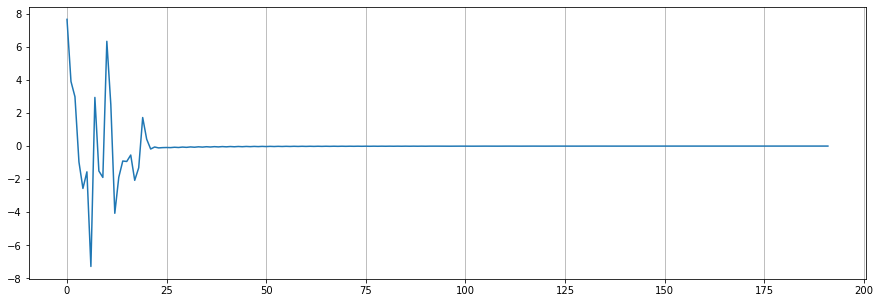

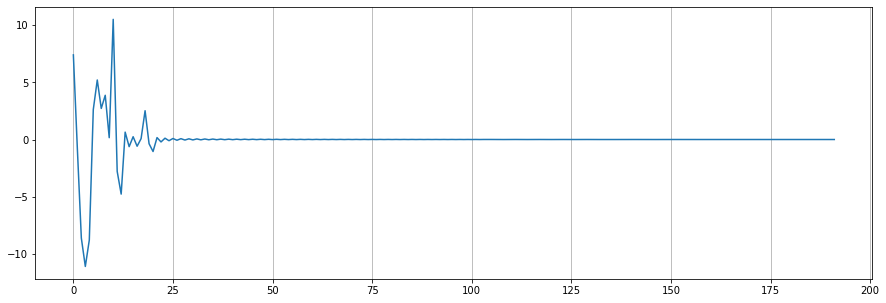

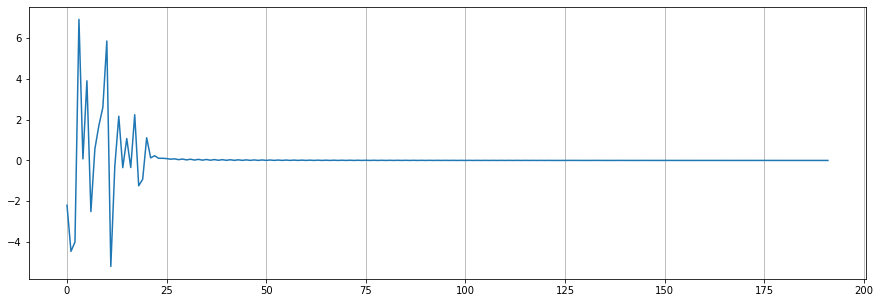

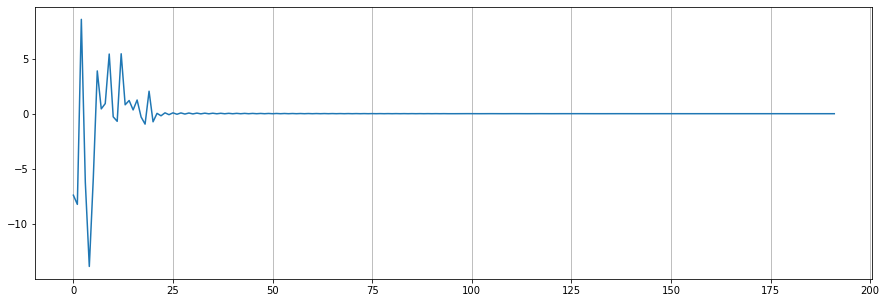

In [5]:
for i in range(sections):
    plt.figure(figsize=(15,5))
    plt.grid(True, which='both', axis='x')
    sec = y[i * N: (i+1) * N]
    plt.plot(D.T @ sec)

Looking at the above graphs, the given audio signal is composed only of lower frequency waves; the higher frequency values are almost nonexistent!  What we can do here to compress our signal is to save the first $m$ basis vectors and completely disregard the rest.  Now we only need to store $m$ values for each section instead of $192$.

We will use the plots above to find (or estimate) a value of $m$ that best represents the data. For this example, we will use $m = 30$. 


In [6]:
m = 30

**Check your answers!**

Now, create a matrix `D_trunc` that has only the first $m$ basis vectors (columns) of ${\bf D}$.

In [7]:
#grade (enter your code in this cell - DO NOT DELETE THIS LINE) 
D_trunc = D[:,: m]

**Check your answers!**

With our truncated basis matrix, we can now compress our audio signal. Following the code snippet used to generate the plots, for each section `sec` of the data stored in `y`, we:

- convert `sec` to the truncated basis using the `D_trunc` matrix above &mdash; this will lose some of the information we have stored.

- convert back to the standard basis and save it in `y_trunc`.

Hints:

- The loop above that generated the plots can help you getting the correct slices of `y` to create `sec`.

- `y_trunc` has the same size of `y`. You should use the same slicing when creating `y_trunc`

- you have done this before, when generating ${\bf w}_k$ in the previous question!

In [15]:
#grade (enter your code in this cell - DO NOT DELETE THIS LINE) 
y_trunc = np.zeros_like(y)
for i in range(sections):
    # A specific section of y (Look at the above plots code)
    sec = y[i * N: (i+1) * N] #len(y) // m
    # How can you convert and truncate using one matrix multiplication?
    sec_bar = np.transpose(D_trunc) @ sec
    # convert back to the original basis and store in the correct portion of y_trunc
    y_trunc[i * N: (i+1) * N] = D_trunc @ sec_bar

Now plot the original `y` values against those in `y_trunc`.  Is this a good approximation?

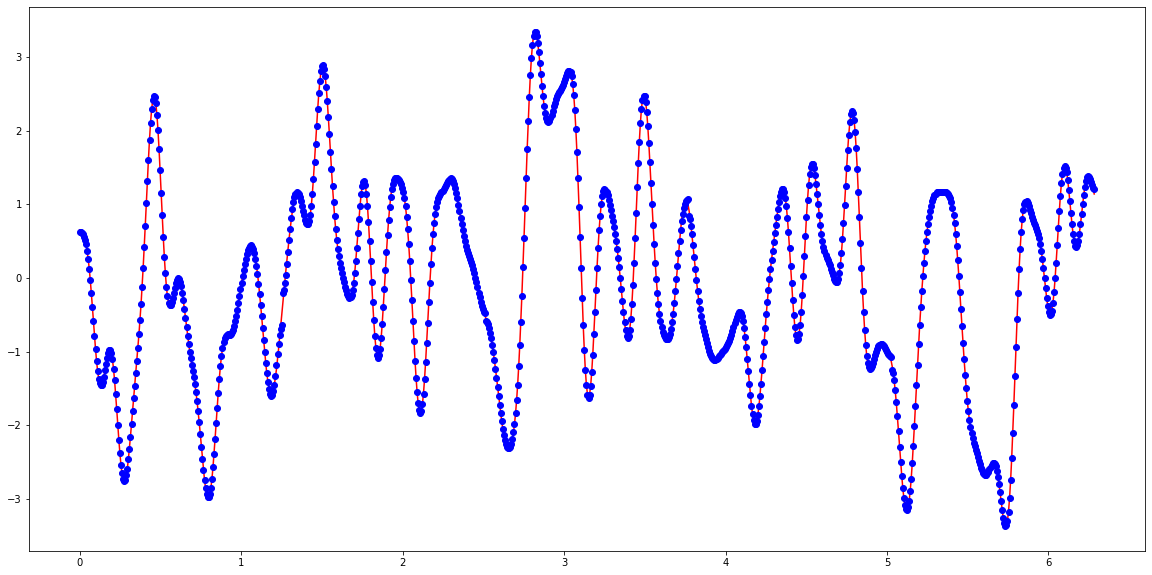

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x, y, '-r')
plt.plot(x, y_trunc, 'ob')

Go back and try some lower values and see what happens. (i.e. $m=2, 5, 10,$ etc). Then go back to $m=30$ for the autograder check. You will see that even with $m = 15$, we are already getting a pretty good approximation!

At low enough values of $m$ you may notice that section boundaries become visible and the waves are no longer continuous.  Real implementations such as MP3 use overlapping sections to help prevent this, but we have omitted this for simplicity.